# LWR Solver — API Test Notebook

Interactive tests for the `numerical_solvers.lwr` public API:
- Initial condition builders: `riemann`, `random_piecewise`, `from_steps`
- Solvers: `generate_one`, `generate_n`
- Greenshields flux: $Q(\rho) = \rho(1 - \rho)$

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from numerical_solvers.lwr import (
    generate_one,
    generate_n,
    riemann,
    random_piecewise,
    from_steps,
)

%matplotlib inline

# Shared grid parameters
NX = 50
DX = 0.02
DT = 0.01
NT = 100

## 1. Single Riemann Problem (Shock)

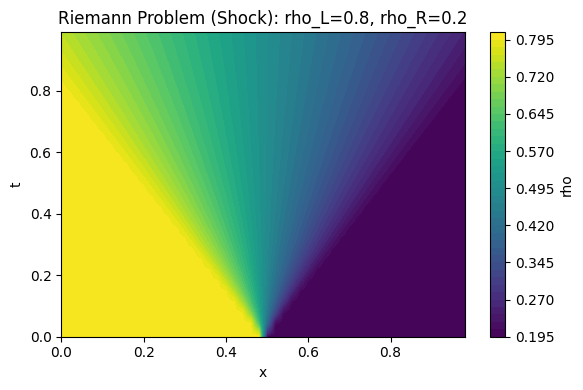

rho shape: torch.Size([100, 50])
x   shape: torch.Size([50])
t   shape: torch.Size([100])


In [2]:
ks, xs = riemann(rho_left=0.8, rho_right=0.2)
sol = generate_one(ks, xs, nx=NX, nt=NT, dx=DX, dt=DT)

fig, ax = plt.subplots(figsize=(6, 4))
c = ax.contourf(
    sol["x"].numpy(),
    sol["t"].numpy(),
    sol["rho"].numpy(),
    levels=40,
    cmap="viridis",
)
fig.colorbar(c, ax=ax, label="rho")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("Riemann Problem (Shock): rho_L=0.8, rho_R=0.2")
fig.tight_layout()
plt.show()

print(f"rho shape: {sol['rho'].shape}")
print(f"x   shape: {sol['x'].shape}")
print(f"t   shape: {sol['t'].shape}")

## 2. Riemann Problem (Rarefaction)

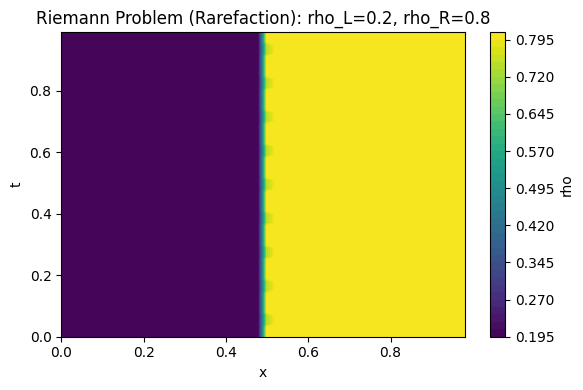

In [3]:
ks, xs = riemann(rho_left=0.2, rho_right=0.8)
sol_rar = generate_one(ks, xs, nx=NX, nt=NT, dx=DX, dt=DT)

fig, ax = plt.subplots(figsize=(6, 4))
c = ax.contourf(
    sol_rar["x"].numpy(),
    sol_rar["t"].numpy(),
    sol_rar["rho"].numpy(),
    levels=40,
    cmap="viridis",
)
fig.colorbar(c, ax=ax, label="rho")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("Riemann Problem (Rarefaction): rho_L=0.2, rho_R=0.8")
fig.tight_layout()
plt.show()

## 3. Custom Piecewise IC (`from_steps`)

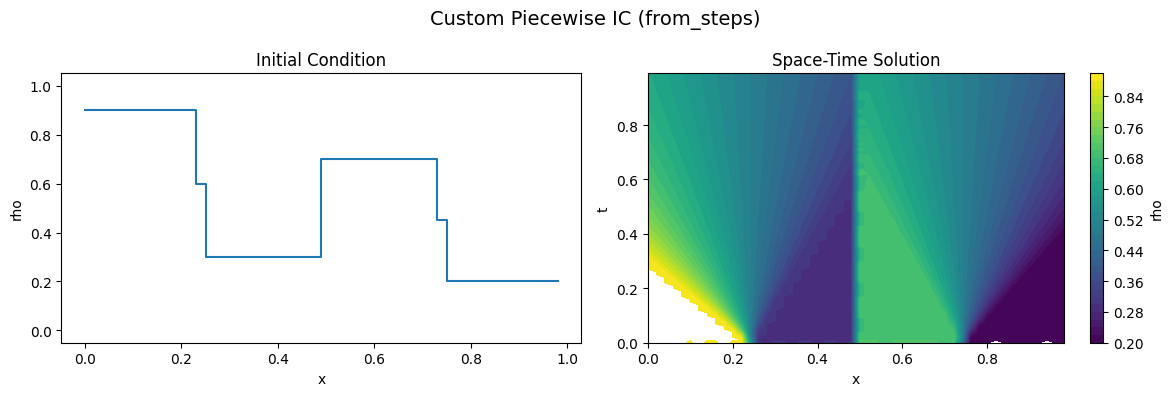

In [4]:
ks, xs = from_steps([0.9, 0.3, 0.7, 0.2], xs=[0, 0.25, 0.5, 0.75, 1.0])
sol_s = generate_one(ks, xs, nx=NX, nt=NT, dx=DX, dt=DT)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# IC profile
axes[0].step(
    sol_s["x"].numpy(),
    sol_s["rho"][0].numpy(),
    where="mid",
)
axes[0].set_xlabel("x")
axes[0].set_ylabel("rho")
axes[0].set_title("Initial Condition")
axes[0].set_ylim(-0.05, 1.05)

# Space-time solution
c = axes[1].contourf(
    sol_s["x"].numpy(),
    sol_s["t"].numpy(),
    sol_s["rho"].numpy(),
    levels=40,
    cmap="viridis",
)
fig.colorbar(c, ax=axes[1], label="rho")
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_title("Space-Time Solution")

fig.suptitle("Custom Piecewise IC (from_steps)", fontsize=14)
fig.tight_layout()
plt.show()

## 4. Random Piecewise IC (`random_piecewise`)

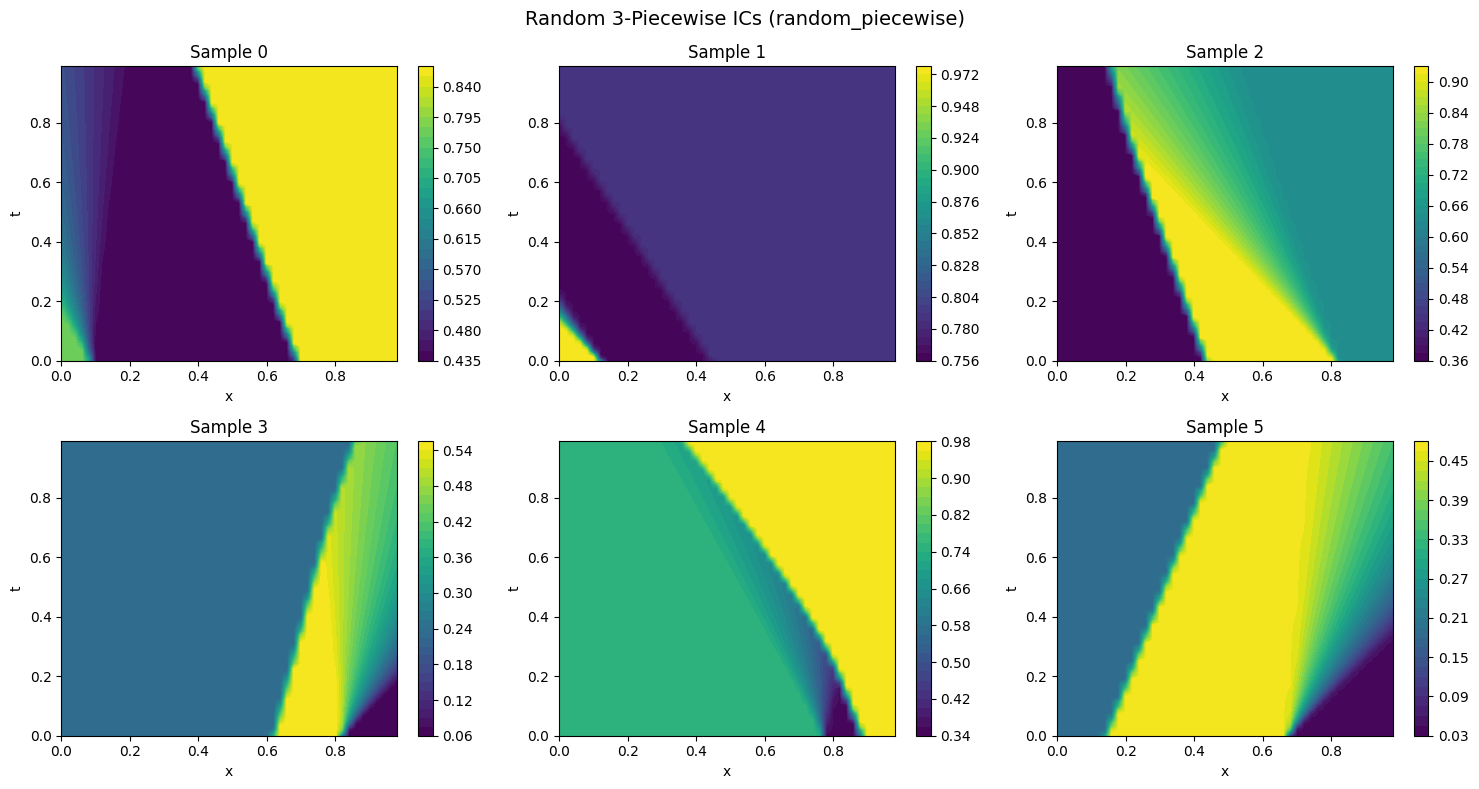

In [5]:
rng = np.random.default_rng(42)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    ks, xs = random_piecewise(k=3, rng=rng)
    sol_rp = generate_one(ks, xs, nx=NX, nt=NT, dx=DX, dt=DT)
    c = ax.contourf(
        sol_rp["x"].numpy(),
        sol_rp["t"].numpy(),
        sol_rp["rho"].numpy(),
        levels=40,
        cmap="viridis",
    )
    fig.colorbar(c, ax=ax)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_title(f"Sample {i}")

fig.suptitle("Random 3-Piecewise ICs (random_piecewise)", fontsize=14)
fig.tight_layout()
plt.show()

## 5. Shocks vs Rarefactions (`only_shocks`)

100%|██████████| 1/1 [00:00<00:00, 24.08it/s]


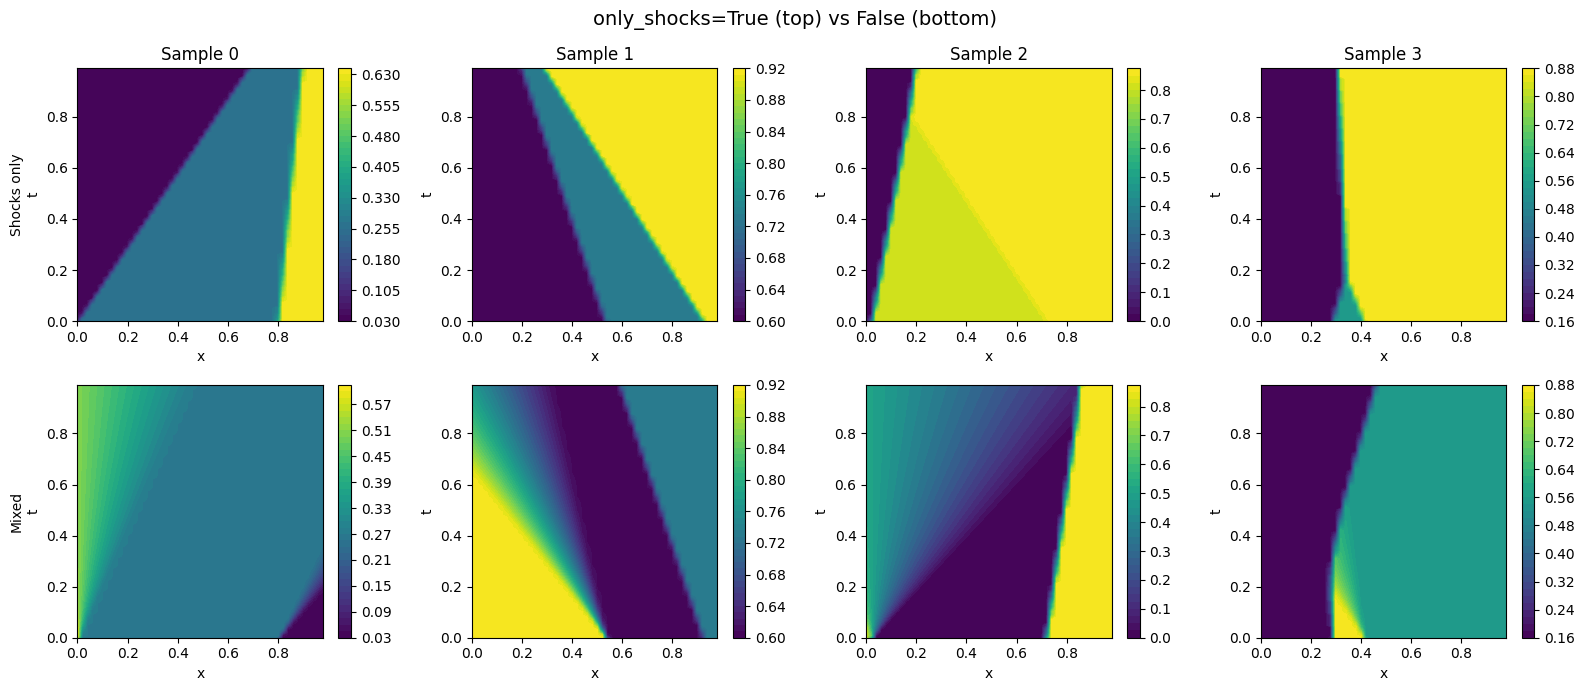

In [6]:
batch_shocks = generate_n(
    n=4, k=3, nx=NX, nt=NT, dx=DX, dt=DT,
    only_shocks=True, seed=0,
)
batch_mixed = generate_n(
    n=4, k=3, nx=NX, nt=NT, dx=DX, dt=DT,
    only_shocks=False, seed=0,
)

fig, axes = plt.subplots(2, 4, figsize=(16, 7))
for col in range(4):
    for row, (batch, label) in enumerate(
        [(batch_shocks, "Shocks only"), (batch_mixed, "Mixed")]
    ):
        ax = axes[row, col]
        c = ax.contourf(
            batch["x"].numpy(),
            batch["t"].numpy(),
            batch["rho"][col].numpy(),
            levels=40,
            cmap="viridis",
        )
        fig.colorbar(c, ax=ax)
        ax.set_xlabel("x")
        ax.set_ylabel("t")
        if col == 0:
            ax.set_ylabel(f"{label}\nt")
        ax.set_title(f"Sample {col}" if row == 0 else "")

fig.suptitle("only_shocks=True (top) vs False (bottom)", fontsize=14)
fig.tight_layout()
plt.show()

## 6. Batch Generation (`generate_n`)

2it [00:00, 30.72it/s]               


rho shape: torch.Size([6, 100, 50])
x   shape: torch.Size([50])
t   shape: torch.Size([100])


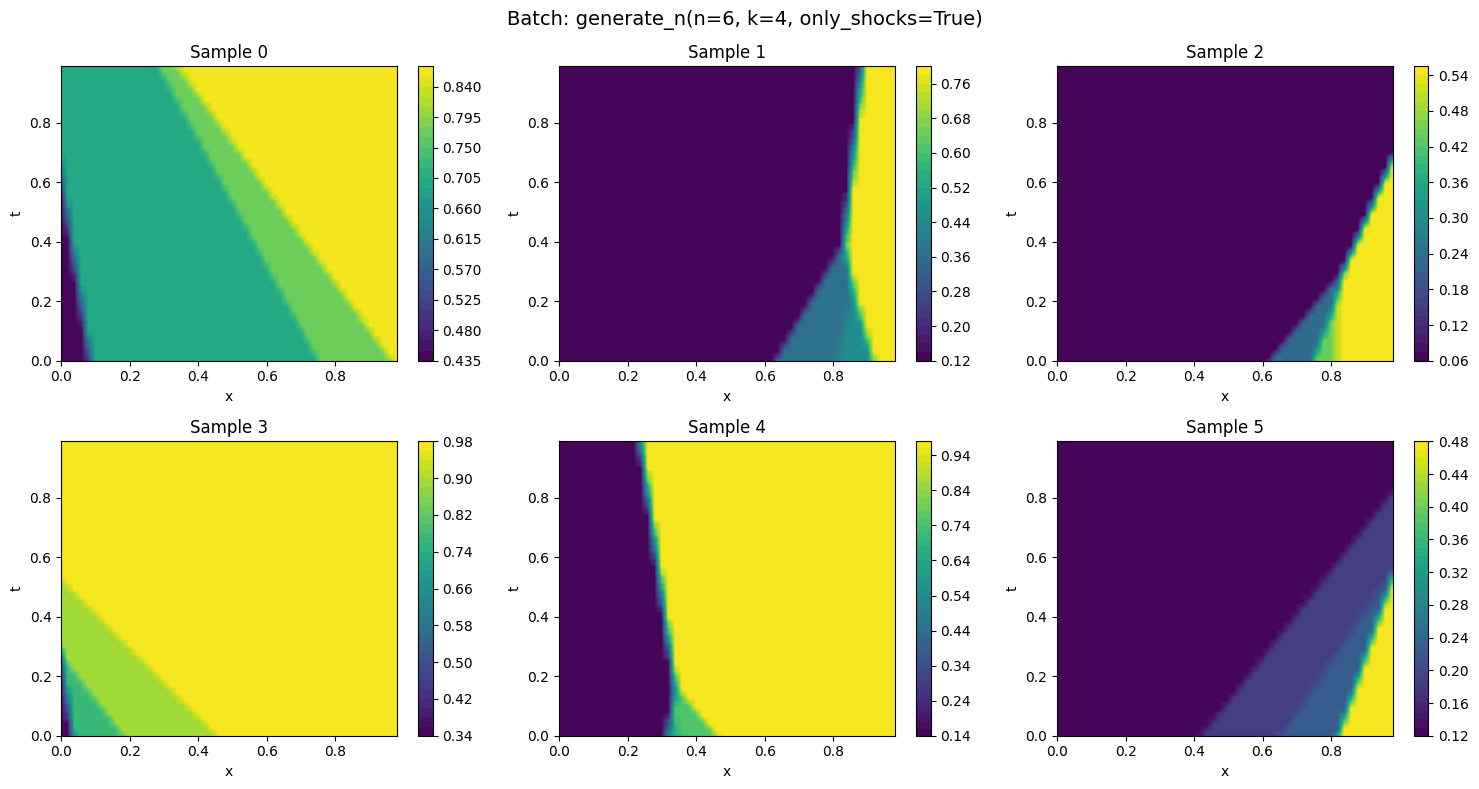

In [7]:
batch = generate_n(
    n=6, k=4, nx=NX, nt=NT, dx=DX, dt=DT,
    only_shocks=True, seed=42,
)

print(f"rho shape: {batch['rho'].shape}")
print(f"x   shape: {batch['x'].shape}")
print(f"t   shape: {batch['t'].shape}")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    c = ax.contourf(
        batch["x"].numpy(),
        batch["t"].numpy(),
        batch["rho"][i].numpy(),
        levels=40,
        cmap="viridis",
    )
    fig.colorbar(c, ax=ax)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_title(f"Sample {i}")

fig.suptitle("Batch: generate_n(n=6, k=4, only_shocks=True)", fontsize=14)
fig.tight_layout()
plt.show()

## 7. Greenshields Flux

The LWR model uses the Greenshields flux $Q(\rho) = \rho(1 - \rho)$, with characteristic speed $Q'(\rho) = 1 - 2\rho$.

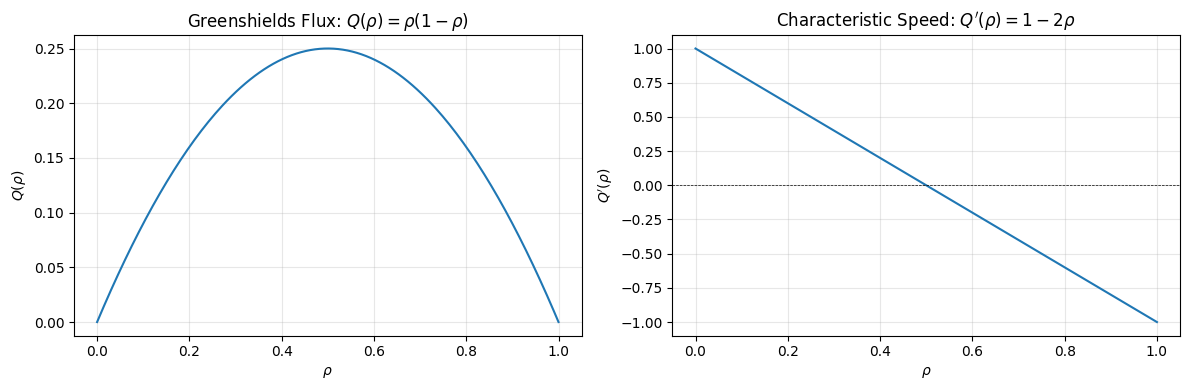

Shock speed (rho_L=0.8, rho_R=0.2): s = -0.0000
  = 1 - rho_L - rho_R = -0.0000


In [8]:
rho = np.linspace(0, 1, 200)
flux = rho * (1 - rho)
char_speed = 1 - 2 * rho

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(rho, flux)
axes[0].set_xlabel(r"$\rho$")
axes[0].set_ylabel(r"$Q(\rho)$")
axes[0].set_title(r"Greenshields Flux: $Q(\rho) = \rho(1-\rho)$")
axes[0].grid(True, alpha=0.3)

axes[1].plot(rho, char_speed)
axes[1].axhline(0, color="k", linewidth=0.5, linestyle="--")
axes[1].set_xlabel(r"$\rho$")
axes[1].set_ylabel(r"$Q'(\rho)$")
axes[1].set_title(r"Characteristic Speed: $Q'(\rho) = 1 - 2\rho$")
axes[1].grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

# Verify shock speed via Rankine-Hugoniot: s = [Q] / [rho]
rho_L, rho_R = 0.8, 0.2
shock_speed = (rho_R * (1 - rho_R) - rho_L * (1 - rho_L)) / (rho_R - rho_L)
print(f"Shock speed (rho_L={rho_L}, rho_R={rho_R}): s = {shock_speed:.4f}")
print(f"  = 1 - rho_L - rho_R = {1 - rho_L - rho_R:.4f}")